In [89]:
import pandas as pd
import numpy as np
from math import floor
import math
import os
from datetime import datetime
import xarray as xr
from tqdm.notebook import tqdm
from sklearn import preprocessing
from time import time
from joblib import dump, load

In [2]:
def guarda_dataframe(df,nombre,subcarpeta = False):
    """
    Guarda el dataframe pasado como parametro en formato .pkl y .xlsx
    
    Parametros:
    df -- dataframe a guardar
    nombre -- nombre de los ficheros a guardar
    subcarpeta -- en caso de ser True, guarda los ficheros en una 
                subcarpeta, en caso contrario, se guarda en el 
                directorio actual
    """
    if subcarpeta:
        df.to_pickle('./pkls/{}.pkl'.format(nombre))
        df.to_excel('./Excels/{}.xlsx'.format(nombre))
    else:
        df.to_pickle('{}.pkl'.format(nombre))
        df.to_excel('{}.xlsx'.format(nombre))
    


# Listado de playas con avistamientos y fechas

## con primer grupo de datos

In [3]:
avistamientos_df = pd.read_excel("./#ExcelsAvistamientosIniciales/Physalia_Ambiental_R.xlsx")
# avistamientos_df = pd.read_excel("../Physala_Data/Datos_Physalia_20171010.xls")

columnas = avistamientos_df.iloc[0]

#Quito las 3 primeras filas, debido al formato de la excell
avistamientos_df = avistamientos_df.iloc[3:] 
avistamientos_df.columns = columnas

# Me quedo solo con los datos de avistamientos
avistamientos_df = avistamientos_df[["Latitud","Longitud","Año","Mes","Día","Avistamientos"]]

#Transdormaciones para sacar con fecha (datetime)
avistamientos_fecha_df=avistamientos_df[["Año","Mes","Día"]]
avistamientos_fecha_df.columns = ["year","month","day"]

fecha = pd.to_datetime(avistamientos_fecha_df)

avistamientos_df["Fecha"]=fecha
avistamientos_df=avistamientos_df[["Latitud","Longitud","Fecha","Avistamientos"]]
avistamientos_df

,Latitud,Longitud,Fecha,Avistamientos
3,-25.4,-70.4833,2014-05-01,1
4,-18.4631,-70.3053,2014-05-01,1
5,-27.0658,-70.8259,2014-05-09,13
6,-18.4933,-70.3261,2014-05-10,15
7,-27.122,-70.8576,2014-05-10,23
...,...,...,...,...
671,-27.1176,-70.8552,2016-03-12,2
672,-27.0833,-70.8431,2016-03-12,2
673,-26.9905,-70.7899,2016-03-12,2
674,-26.9905,-70.7899,2016-03-13,5


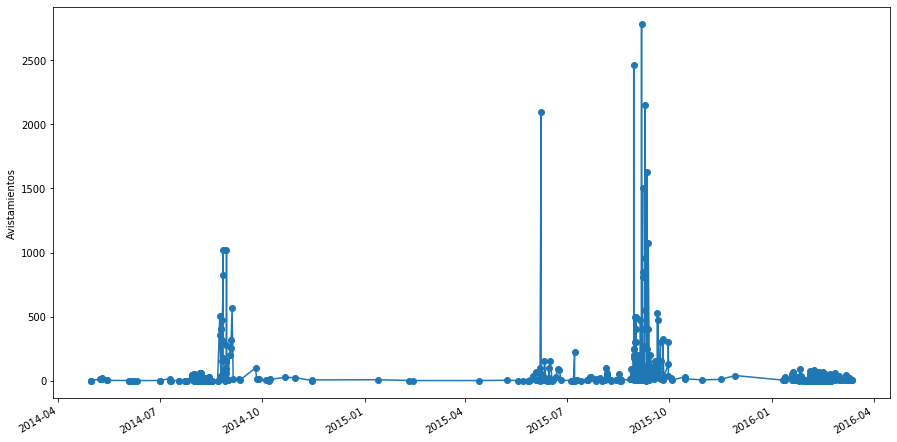

In [4]:
import matplotlib.pyplot as plt
plot_size = (15, 8)
# ordeno valores 
a = avistamientos_df.sort_values(by='Fecha')[['Fecha','Avistamientos']]
a = a.set_index('Fecha')

# gráfica de la serie temporal
ax = a.plot(figsize=plot_size, marker='o', legend=False)
ax.set(xlabel='', ylabel='Avistamientos')
plt.show()

## con segundo grupo de datos

In [5]:
avistamientos_2_df = pd.read_excel("./#ExcelsAvistamientosIniciales/Datos_Physalia_20171010.xls")

# elimino filas con tipo de atributo "Categoria" que van del 1 al tres y no siguen la mismas reglas que los numericos
avistamientos_2_df = avistamientos_2_df[avistamientos_2_df['Tipo.Abund'] == 'numero']
# cambio signo de coordenadas 
avistamientos_2_df['Lat.dec'] = avistamientos_2_df['Lat.dec'].multiply(-1)
avistamientos_2_df['Long.dec'] = avistamientos_2_df['Long.dec'].multiply(-1)

#filtro las columnas que nos interesan
avistamientos_2_df = avistamientos_2_df[['Lat.dec','Long.dec','Date','Abundancia']]
avistamientos_2_df.columns = ['Latitud','Longitud','Fecha','Avistamientos']

In [6]:
#filas sin datos
filas_nan = avistamientos_2_df[avistamientos_2_df.isna().any(axis=1)] # filas con valores vacios
print(filas_nan)
# eliminar esas filas
avistamientos_2_df = avistamientos_2_df.drop(filas_nan.index.values)


      Latitud  Longitud      Fecha  Avistamientos
1121      NaN       NaN 2017-03-31             30
1129      NaN       NaN 2017-04-06             21
1143      NaN       NaN 2017-04-09              6
1220      NaN       NaN 2017-05-16             80


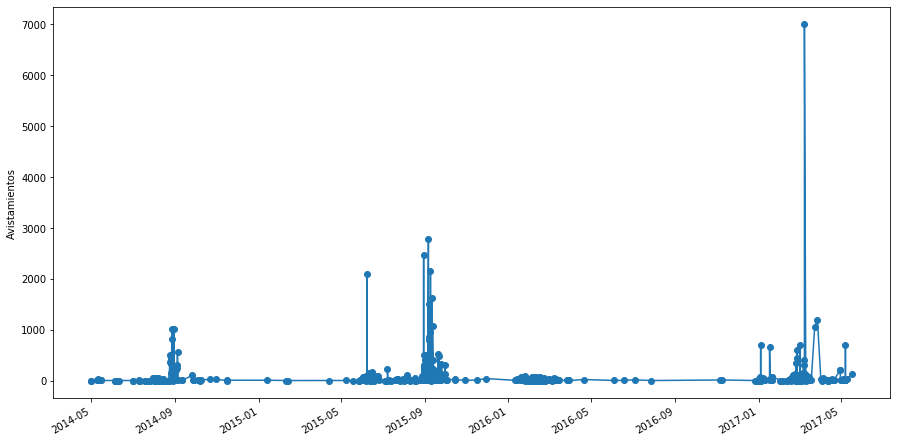

In [7]:
import matplotlib.pyplot as plt
plot_size = (15, 8)
# ordeno valores 
a = avistamientos_2_df.sort_values(by='Fecha')[['Fecha','Avistamientos']]
a = a.set_index('Fecha')

# gráfica de la serie temporal
ax = a.plot(figsize=plot_size, marker='o', legend=False)
ax.set(xlabel='', ylabel='Avistamientos')
plt.show()

In [8]:
#guarda df
guarda_dataframe(avistamientos_2_df,'1_avistamientos_origen')

avistamientos_2_df

,Latitud,Longitud,Fecha,Avistamientos
0,-18.463056,-70.305278,2014-05-01,1
1,-25.400000,-70.483333,2014-05-01,1
2,-27.065847,-70.825936,2014-05-09,13
3,-18.493333,-70.326111,2014-05-10,15
4,-27.121997,-70.857606,2014-05-10,23
...,...,...,...,...
1209,-33.359197,-71.669692,2017-05-07,6
1210,-34.756150,-71.486914,2017-05-08,700
1211,-41.858347,-74.020769,2017-05-08,20
1218,-33.022886,-71.569536,2017-05-10,33


In [9]:
## para leer los .pkl
# a  = pd.read_pickle('1_avistamientos.pkl')

# Redondeo con salto entre cuadrantes de dataSet original (0,0833)
Redondeo de latitud y longitud para juntar lecturas de una misma playa con coordenadas muy proximas

Se exporta el dataframe generado a un excel

In [10]:
df_avistamientos  = pd.read_pickle('1_avistamientos_origen.pkl')

In [11]:
def redondeo(coordenadas, base=1/12):
    """
    Devuelve las coordenadas pasadas redondeadas
    
    Parametros:
    coordenadas -- lista de latitud y longitud
    base -- base del redondeo
    """
    return  base * round(coordenadas/base)

#Se añaden atributos con la longitud y latitud redondeadas a cada cuarto de grado
df_avistamientos["Lat_floor"] = df_avistamientos.Latitud.map(redondeo)
df_avistamientos["Long_floor"] = df_avistamientos.Longitud.map(redondeo)

#Descarto latitudes sin redondear
df = df_avistamientos[['Lat_floor', 'Long_floor',"Fecha","Avistamientos"]]

#DataFrame total avistamientos de playas en esa cuadricula
df_sum = df.groupby(['Lat_floor', 'Long_floor',"Fecha"]).sum()

#DataFrame número de playas en esa cuadricula
df_count = df.groupby(['Lat_floor', 'Long_floor',"Fecha"]).count()

#Dataframe con el total de avistamientos y el número de playas
df_join = df_sum.join(df_count,lsuffix="I",rsuffix="R")
df_join.columns=['Suma', 'N_Playas']
df_join['Media_Playas'] = df_join.Suma /df_join.N_Playas

#Se ordenan temporalmente
df_join = df_join.sort_values(by=['Fecha','Lat_floor','Long_floor' ]).reset_index().set_index(['Fecha','Lat_floor','Long_floor' ])

# DataFrame de avistamientos procesado
guarda_dataframe(df_join,'2_avistamientos_redondeo')


In [12]:
df_join

Suma  N_Playas  Media_Playas
Fecha      Lat_floor  Long_floor                              
2014-05-01 -25.416667 -70.500000     1         1           1.0
           -18.500000 -70.333333     1         1           1.0
2014-05-09 -27.083333 -70.833333    13         1          13.0
2014-05-10 -27.083333 -70.833333    23         1          23.0
           -18.500000 -70.333333    15         1          15.0
...                                ...       ...           ...
2017-05-08 -34.750000 -71.500000   700         1         700.0
           -27.333333 -70.916667     5         1           5.0
           -27.083333 -70.833333    15         2           7.5
2017-05-10 -33.000000 -71.583333    33         1          33.0
2017-05-18 -41.833333 -73.500000   133         1         133.0

[668 rows x 3 columns]

# Estructura uniendo avistamientos y condiciones oceánicas

In [13]:
df_join = pd.read_pickle('2_avistamientos_redondeo.pkl')

In [14]:
df_playas = df_join.reset_index()
# Cojo las columnas que me interesan
df_playas = df_playas[["Suma","Lat_floor","Long_floor","Fecha"]]
# Renombro las columnas 
df_playas = df_playas.rename(columns={"Suma": "Avistamientos", "Lat_floor": "Latitud", "Long_floor": "Longitud"})
# Ordeno por fecha
df_playas = df_playas.sort_values(by=["Fecha"])
guarda_dataframe(df=df_playas,nombre='2_avistamientos_redondeo')

### características

In [15]:
df_playas # DataFrame con avistamientos en cada playa
cuadrantes = { # Numero de cuadrantes que se concatenarán con las playas
    'izquierda': 0 ,
    'arriba': 0 ,
    'abajo': 0
}
dias_desfase = 15
salto = 1/12 # Salto de coordenadas entre los cuadrantes
listado_archivos = os.listdir('W:\DatosCopernicusTFG\descargas') # Listo todos los archivos de Copernicus
variables = ['Coord','Profundidad','mlotst','zos','bottomT','thetao','so','uo','vo']

In [16]:
def busca_archivo(fecha):
    """
    Devuelve el archivo .nc de la fecha pasada por parametro
    
    Parametros:
    fecha -- fecha en formato AñoMesDia (20140105)
    """
    texto ='_{}_'.format(str(fecha).split()[0].replace('-',''))
    archivo = [x for x in listado_archivos if str(texto) in x]
    data = xr.open_dataset('W:\DatosCopernicusTFG\descargas\{}'.format(archivo[0])) # cargo el archivo
    return data # devuelvo dataset

def dame_datos(latitud,longitud,ds):
    """
    Devuelve los datos del dataset en las coordenadas pasadas
    
    Parametros:
    latitud -- latitud 
    longitud -- longitud
    ds -- dataset del que extraer los valores
    """
    return ds.sel({'latitude':latitud,'longitude': longitud})

def comprueba_datos(latitud,longitud,ds):
    """
    Comprueba si el dataset contiene valores en las coordenadas pasadas
    
    Devuelve las coordenadas mas cercanas con datos 
    
    Parametros:
    latitud -- latitud
    longitud -- longitud
    ds -- dataset del que extraer los valores
    """
    valor = dame_datos(latitud,longitud,ds)
    while math.isnan(valor.mlotst[0]):
        longitud = longitud - salto
        valor = dame_datos(latitud,longitud,ds)
    return latitud,longitud # devuelvo las coordenadas con datos

def crea_DF():
    """
    Devuelve un dataframe con las columnas especificadas teniendo en cuenta los valores de le diccionario "cuadrantes"
    """
    df_resultados = None
    df_resultados = pd.DataFrame(columns=["Avistamientos","Latitud","Longitud","Fecha",'Coord',"Profundidad","mlotst",'zos','bottomT','thetao','so','uo','vo']) # columnas básicas
    for izquierda in range(cuadrantes['izquierda']): # por cada cuadrante a la izquierda meto un grupo de columnas
        var_aux = [str(x+'_izq_'+str(izquierda+1)) for x in variables]
        df_aux = pd.DataFrame(columns=var_aux)
        df_resultados = df_resultados.join(df_aux)
        for superior in range (cuadrantes['arriba']): # por cada cuadrante a la superior meto un grupo de columnas
            var_aux = [x+'_sup_'+str(izquierda+1)+'.'+str(superior+1) for x in variables]
            df_aux = pd.DataFrame(columns=var_aux)
            df_resultados = df_resultados.join(df_aux)
        for inferior in range (cuadrantes['abajo']): # por cada cuadrante a la inferior meto un grupo de columnas    
            var_aux = [x+'_inf_'+str(izquierda+1)+'.'+str(inferior+1) for x in variables]
            df_aux = pd.DataFrame(columns=var_aux)
            df_resultados = df_resultados.join(df_aux)
    return df_resultados

def meto_en_df(df_resultados,row,coordenadas,df,indice,variables_actuales):
    """
    Introduce los valores en el dataframe df_resultados
    
    Parametros:
    df_resultados -- dataframe al que añadir los valores de coordenadas y variables
    row -- valores de numero de avistamientos, coordenadas y fecha del avistamiento
    coordenadas -- coordenadas de las variables
    df -- dataframe con las variables oceanicas
    indice -- linea en la uqe insetar la linea
    variables_actuales -- variables en las que introducir los valores pasados en df
    """
    for x in range(3):
        df_resultados.loc[indice + x,["Avistamientos","Latitud","Longitud","Fecha"]] = row.values.tolist() # meto en df_resulados los datos de ese cuadrante
        vars = df.loc[x,['depth', 'mlotst','zos','bottomT','thetao','so','uo','vo']].values.tolist()
        vars.insert(0,coordenadas)
        df_resultados.loc[indice + x,variables_actuales] = vars # meto coordenadas reales utilizadas y datos 
    return df_resultados

def dameCoordIzq(lat,long,n_saltos):
    """
    Devuelve las coordenadas del siguiente cuandrante a la izquierda
    
    Parametros:
    lat -- latitud
    long -- longitud
    n_saltos -- numero de cuadrantes a saltar
    """
    return [lat,long-(salto*n_saltos)]

def dameCoordSuperior(lat,long,n_saltos):
    """
    Devuelve las coordenadas del siguiente cuadrante por arriba
    
    Parametros:
    lat -- latitud
    long -- longitud
    n_saltos -- numero de cuadrantes a saltar
    """
    coordenadas = dameCoordIzq(lat,long,n_saltos)
    return [lat+(salto*n_saltos),long]

def dameCoordInferior(lat,long,n_saltos):
    """
    Devuelve las coordenadas del siguiente cuandrante por abajo
    
    Parametros:
    lat -- latitud
    long -- longitud
    n_saltos -- numero de cuadrantes a saltar
    """
    return [lat-(salto*n_saltos),long]

def resta_fecha(fecha,dias):
    """
    Devuelve la fecha restando en numero de dias indicado
    
    Parametros:
    fecha -- fecha en formato AñoMesDia (20140105)
    dias -- numero de dias a restar
    """
    return fecha - pd.Timedelta(days=dias)

In [17]:
# x = df = pd.read_pickle('2_avistamientos_redondeo.pkl')
# x = x.loc[5]
# print(x['Fecha'])
# ds = busca_archivo(resta_fecha(x['Fecha'],0)) # busco el archivo de la fecha 


In [82]:
def crea_estr(df):
    """
    Devuelve un data frame con los a vistamientos y los datos oceanicos asociados a las coordenadas de los mismos
    """
    df_resultados = crea_DF() # creo df con columnas necesarias
    #print(df_resultados)
    total_lineas = df.shape[0]
    pbar = tqdm(total = total_lineas)
    for contador,[index, row] in enumerate(df.iterrows()): # por cada playa
#         print(contador,end='\r')
        pbar.update(1)
        ds = busca_archivo(resta_fecha(row['Fecha'],dias_desfase)) # busco el archivo de la fecha 
        coordenadas = comprueba_datos(row['Latitud'],row['Longitud'],ds) # miro a ver si el cuadrante tiene datos, sino cojo el siguiente por la izquierda

        df = dame_datos(coordenadas[0],coordenadas[1],ds).to_dataframe().reset_index() # dataframe con los datso oceanicos de esas coordenadas y en esa fecha
        df_resultados = meto_en_df(df_resultados,row,list(coordenadas),df,contador * 3,variables)
#         print('--{}'.format(contador))
        # datos de las celdas extras
        for izquierda in range(cuadrantes['izquierda']): # por cada cuadrante a la izquierda, añado datos
            coordenadas = dameCoordIzq(coordenadas[0],coordenadas[1],izquierda+1)
            df = dame_datos(coordenadas[0],coordenadas[1],ds).to_dataframe().reset_index() 
            var_aux = [x+'_izq_'+str(izquierda+1) for x in variables]
            df_resultados = meto_en_df(df_resultados,row,coordenadas,df,contador * 3,var_aux)
            coord_aux = coordenadas
            for superior in range (cuadrantes['arriba']): # por cada cuadrante a la superior, añado datos
                coord_aux = dameCoordSuperior(coord_aux[0],coord_aux[1],superior+1)
                df = dame_datos(coord_aux[0],coord_aux[1],ds).to_dataframe().reset_index() 
                var_aux = [x+'_sup_'+str(izquierda+1)+'.'+str(superior+1) for x in variables]
                df_resultados = meto_en_df(df_resultados,row,coord_aux,df,contador * 3,var_aux)
            coord_aux = coordenadas
            for inferior in range (cuadrantes['abajo']): # por cada cuadrante a la inferior, añado datos  
                coord_aux = dameCoordInferior(coord_aux[0],coord_aux[1],inferior+1)
                df = dame_datos(coord_aux[0],coord_aux[1],ds).to_dataframe().reset_index() 
                var_aux = [x+'_inf_'+str(izquierda+1)+'.'+str(inferior+1) for x in variables]
                df_resultados = meto_en_df(df_resultados,row,coord_aux,df,contador * 3,var_aux)

#         if contador == 5:
#             break
    return df_resultados

In [19]:
# creo estructura de datos

# df_resultados = crea_estr(df_playas)
# df_resultados.head()

In [20]:
# df_resultados.head()

In [21]:
# #Guardo la estructura
# df_resultados = df_resultados.reset_index().set_index(['Fecha','Latitud','Longitud','Avistamientos','Profundidad'])
# guarda_dataframe(df_resultados,nombre='3_estructura')
# df_resultados.to_excel('3EstructuraFinal.xlsx')
# df_resultados.head()

In [22]:
# for i in [0,7,14,30,45,60]:
#     dias_desfase = i
#     df_resultados = crea_estr()
#     df_resultados = df_resultados.reset_index().set_index(['Latitud','Longitud','Fecha','Avistamientos','Profundidad'])
#     df_resultados.to_excel('-EstructuraFinal{}dias.xlsx'.format(i))
# df_resultados.head()

## Estructura sin rellenar huecos sin datos

In [23]:
# def crea_estr():
#     df_resultados = crea_DF() # creo df con columnas necesarias
#     #print(df_resultados)
#     total_lineas = df_playas.shape[0]
#     pbar = tqdm(total = total_lineas)
#     for contador,[index, row] in enumerate(df_playas.iterrows()): # por cada playa
# #         print(contador,end='\r')
#         pbar.update(1)
#         ds = busca_archivo(row['Fecha']) # busco el archivo de la fecha 
#         coordenadas = [row['Latitud'],row['Longitud']]

#         df = dame_datos(row['Latitud'],row['Longitud'],ds).to_dataframe().reset_index() # dataframe con los datso oceanicos de esas coordenadas y en esa fecha
#         df_resultados = meto_en_df(df_resultados,row,[row['Latitud'],row['Longitud']],df,contador * 3,variables)
        
#         # datos de las celdas extras
#         for izquierda in range(cuadrantes['izquierda']): # por cada cuadrante a la izquierda, añado datos
#             coordenadas = dameCoordIzq(coordenadas[0],coordenadas[1],izquierda+1)
#             df = dame_datos(coordenadas[0],coordenadas[1],ds).to_dataframe().reset_index() 
#             var_aux = [x+'_izq_'+str(izquierda+1) for x in variables]
#             df_resultados = meto_en_df(df_resultados,row,coordenadas,df,contador * 3,var_aux)
#             coord_aux = coordenadas
#             for superior in range (cuadrantes['arriba']): # por cada cuadrante a la superior, añado datos
#                 coord_aux = dameCoordSuperior(coord_aux[0],coord_aux[1],superior+1)
#                 df = dame_datos(coord_aux[0],coord_aux[1],ds).to_dataframe().reset_index() 
#                 var_aux = [x+'_sup_'+str(izquierda+1)+'.'+str(superior+1) for x in variables]
#                 df_resultados = meto_en_df(df_resultados,row,coord_aux,df,contador * 3,var_aux)
#             coord_aux = coordenadas
#             for inferior in range (cuadrantes['abajo']): # por cada cuadrante a la inferior, añado datos  
#                 coord_aux = dameCoordInferior(coord_aux[0],coord_aux[1],inferior+1)
#                 df = dame_datos(coord_aux[0],coord_aux[1],ds).to_dataframe().reset_index() 
#                 var_aux = [x+'_inf_'+str(izquierda+1)+'.'+str(inferior+1) for x in variables]
#                 df_resultados = meto_en_df(df_resultados,row,coord_aux,df,contador * 3,var_aux)
        
#     return df_resultados

In [24]:
# df_resultados_con_vacios = crea_estr()

In [25]:
# df_resultados_con_vacios.head()

In [26]:
# df_resultados_con_vacios.to_excel('3EstructuraCoordEnTierra.xlsx')

# Rellenar datos de celdas vacios
Con datos de la coordenada más cercana por la izquierda

In [27]:
def comprueba_datos_thetao(latitud,longitud,ds):
    """
    Comprueba que el dataset pasado tenga datos en las coordenadas especificadas
    
    Devuelve las mismas coordenadas si tienen datos y sino devuelve las del cuadrante por la izquierda 
    mas cercano que contenga
    
    latitud -- latitud
    longitud -- longitud
    ds -- dataset
    """
    valor = dame_datos(latitud,longitud,ds)
    while math.isnan(valor.thetao[0][2]):
        longitud = float(longitud) - salto
        valor = dame_datos(latitud,longitud,ds)
    return latitud,longitud # devuelvo las coordenadas con datos

In [28]:
# datos_excel = pd.read_excel('EstructuraFinal.xlsx').reset_index() # leo estructura de datos que contiene huecos sin informacion
# datos = datos_excel.drop(['Unnamed: 0'],axis=1).sort_values(by=['Latitud','Longitud','Profundidad','Fecha']) 

# datos_excel = df_resultados.copy().reset_index()
# datos = datos_excel.sort_values(by=['Latitud','Longitud','Fecha']) 

In [29]:
# datos

In [87]:
def rellenar_huecos(df):
    """
    Rellena las lineas sin datos en el dataframe recibido y le devuelve completo
    
    Parametros:
    df -- dataframe
    """
    filas_nan = df[df.isna().any(axis=1)] # filas con valores vacios
    datos_copia = df.copy()
    total_lineas = filas_nan.shape[0]
    pbar = tqdm(total = total_lineas)
    for indice, fila in filas_nan.iterrows():
        pbar.update(1)
        for index, value in fila.isna().items():
            if value:
                nombre_original = index
                nombre = 'Coord'
                try:
                    nombre_original = index[:index.index('_')] # nombre de la columna en el DataSet
                    nombre = nombre + index[index.index('_'):] # nombre de la columna de coordenadas de ese punto
                except:
                    pass
                coordenadas = fila[nombre]
#                 coordenadas = [0,0]
#                 coordenadas[0] = coord[1:coord.index(',')]
#                 coordenadas[1] = coord[coord.index(',')+1:coord.index(']')]
                archivo = busca_archivo(fila['Fecha'])
                coordenadas = comprueba_datos_thetao(coordenadas[0],coordenadas[1],archivo)
                datos_fila = dame_datos(coordenadas[0],coordenadas[1],archivo)
                valor =datos_fila.sel({'depth':fila['Profundidad']}).to_dataframe().reset_index()[nombre_original].values[0]
                datos_copia.loc[indice,index] = valor
    return datos_copia

In [62]:
# datos_sin_huecos = rellenar_huecos(datos)

In [63]:
# filas_nan_2 = datos_sin_huecos[datos_sin_huecos.isna().any(axis=1)] # compruebo que se hayan rellenado todos los vacios
# filas_nan_2.head()

In [64]:
# datos_sin_huecos = datos_sin_huecos.reset_index().set_index(['Latitud','Longitud','Fecha','Avistamientos','Profundidad']).drop(['index'],axis = 1)
# datos_sin_huecos.to_excel('4EstructuraFinalSinMissings.xlsx')

In [65]:
# datos_sin_huecos

## Ajustes estructura + normalización

In [35]:
# Estructura quitando las columnas de las coordenadas pues no nos sirven
def cargar(nombre):
    """
    Elimina las columnas que no son de datos para la estructura final del archivo con el nombre pasado
    
    Parametros:
    nombre -- nombre del dataframe a modificar
    """
    df = pd.read_pickle(nombre)
    df = df.fillna(method='ffill', axis=0).set_index(['Latitud','Longitud','Fecha','Avistamientos','Profundidad'])#.drop(['level_0','index'],axis = 1)
    # Eliminar columnas Coords
    cols = [c for c in df.columns if 'Coord' not in c and 'Profundidad' not in c]

    df_inicial=df[cols]

    return df_inicial

In [36]:
profundidades = ['_0','_5','_10']

# añado etiqueta de profundidad
def renombra_atributos(df):
    """
    Renombra las columnas del dataframe pasado con las profundidades 
    
    Parametros:
    df -- dataframe a modificar
    """
    columnas = []
    for i in range(3):
        columnas_aux = df.columns + profundidades[i]
        [columnas.append(x) for x in columnas_aux]
    df_atributos = pd.DataFrame(columns=columnas)
    return df_atributos
# df_atributos

In [37]:
def unifica_lineas(df):
    """
    Se concatenan las filas de las tres profundidades
    
    Parametros:
    df -- dataframe a modificar
    """
    df_atributos = renombra_atributos(df)
    # meto tres profundidades consecutivas
    total_lineas = df.shape[0]/3
    pbar = tqdm(total = total_lineas)
    for cont in range(int(df.shape[0]/3)):
        pbar.update(1)
        inicio = cont*3
        df_aux = df.iloc[inicio:inicio+3]
        lista = list()

        for fila in df_aux.values.tolist():
            for elem in fila :
                lista.append(elem)

        dict_atr = dict(zip(df_atributos.columns,lista))
        df_atr_aux = pd.DataFrame(dict_atr,index=[0])
        df_atributos = pd.concat([df_atributos,df_atr_aux])
    pbar.update(0)
    return df_atributos

In [91]:
from sklearn.preprocessing import MinMaxScaler
def normaliza_min_max(df_atributos,nombre,dias,celdas):
    """
    Normaliza los datos del dataframe pasado
    """
    X = df_atributos.values.tolist()
    min_max = preprocessing.MinMaxScaler()
    normalizador = min_max.fit(X)
    dump(normalizador, 'normalizador.pkl') 
    x_normalizado_2 = min_max.transform(X)
    x_normalizado_2
    df_norm = pd.DataFrame(x_normalizado_2,columns=df_atributos.columns)
#     df_norm.to_excel('dfAtributosNormalizado2_{}.xlsx'.format(nombre[3:]))
    guarda_dataframe(df_norm,'dfAtributosNormalizado_{}_dias_{}_celdas'.format(dias,celdas),True)
    return df_norm

In [39]:
def lista_avistamientos(nombre):
    """
    Agrupa los avistamientos de cada tres filas ya que al concatenar las tres profundidades los avistamientos estaban repetidos
    
    Parametros:
    nombre -- nombre del dataframe a modificar
    """
    df = pd.read_pickle(nombre)
    df = df.fillna(method='ffill', axis=0)#.drop(['level_0','index'],axis = 1)
    listado_avistamientos = df.Avistamientos.values.tolist()
    avistamientos = [x for x in listado_avistamientos[::3]]
    df_avistamientos = pd.DataFrame(avistamientos,columns=['Avistamientos'])
    guarda_dataframe(df_avistamientos,'dfAvistamientos',True)
    return df_avistamientos

In [40]:
def ejecuta(nombre,dias,celdas):
    """
    Coloca las tres profundidades en una misma linea y los normaliza
    
    Devuelve el dataframe normalizado y el dataframe de los avistmaientos
    
    Parametros:
    nombre -- nombre del dataframe a modificar
    dias -- dias de desfase en la fecha
    celdas -- numero de celdas a tener en cuenta alrededor del punto de avistamiento
    """
    df_inicial = cargar(nombre)
    df_atributos = unifica_lineas(df_inicial)
    df_atri_norm = normaliza_min_max(df_atributos,nombre,dias,celdas)
    df_avis_norm = lista_avistamientos(nombre)
    return df_atri_norm,df_avis_norm

# Proceso completo con diferentes configuraciones

In [92]:
# configs = {'num_dias':[0,7,14,30,60],
#            'celdas':[0,2,4]}

configs = {'num_dias':[2],
           'celdas':[2]}

df_revision = None

df = pd.read_pickle('2_avistamientos_redondeo.pkl')
inicio = time()
for d in configs['num_dias']:
    dias_desfase = d # dias de desfase respecto la fecha de avistamiento
    for c in configs['celdas']:
        print('{} minutos'.format((time() - inicio)/60))
        cuadrantes['izquierda'],cuadrantes['arriba'],cuadrantes['abajo'] = c,c,c
        print('{}dias {}celdas'.format(d,c))
        df_res = crea_estr(df)
        df_res = df_res.sort_values(by=['Fecha','Latitud','Longitud'])
        df_revision = df_res
#         print(df_res)
        df_res = rellenar_huecos(df_res)
        guarda_dataframe(df_res,'3estruct_{}dias_{}celdas'.format(d,c),True)
        ejecuta(nombre='./pkls/3estruct_{}dias_{}celdas.pkl'.format(d,c),dias=d,celdas=c)
        
        

0.0 minutos
2dias 2celdas


In [81]:
df_revision
df_revision.to_excel('aaa.xlsx')